In [618]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import random
import pandas as pd
from PIL import Image
from pathlib import Path
from collections import OrderedDict
from time import time, ctime, localtime
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import MinMaxScaler

import torchvision
import torchvision.transforms as transforms

from torchvision import datasets
from torchvision import models

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,  KFold
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor

random_seed = 42
np.random.seed(random_seed)

from xgboost import XGBRegressor

In [950]:
data = pd.read_csv('/kaggle/input/temper/train.csv')
scaler = MinMaxScaler()

In [951]:
data['datetime'] = pd.to_datetime(data['일시'])

In [952]:
data['Year'] = data['datetime'].dt.year
data['Month'] = data['datetime'].dt.month
data['Day'] = data['datetime'].dt.day

In [953]:
# def preprocess(series, window_size=None, scaling=True):

#     if window_size!=None:
#         series = series.rolling(window_size, min_periods=0).mean()
#     array = np.array(series)

#     if scaling==True:
#         scaler = MinMaxScaler()
#         training_data = scaler.fit_transform(array.reshape(-1,1))
#     else:
#         scaler = None

#     return training_data, scaler

In [954]:
# def make_dataset(training_data, t, h=0, test_size=0.1):

#     X_train = []
#     y_train = []
#     for i in range(t//2+365, len(training_data)-h):
#         temp = np.concatenate((training_data[i-t:i],data['Year'][i+h].reshape(1,1)),axis=0)
#         temp = np.concatenate((temp, data['Month'][i+h].reshape(1,1)),axis=0)
#         temp = np.concatenate((temp, data['Day'][i+h].reshape(1,1)),axis=0)
#         X_train.append(temp)
#         y_train.append(training_data[i+h])
#     X = np.array(X_train)
#     y = np.array(y_train)


#     X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)


#     return X_train,X_test,y_train,y_test

In [955]:
# training_data, scaler = preprocess(data['평균기온'], window_size=5)
# X_train,X_test,y_train,y_test = make_dataset(training_data, h=358, t = 30, test_size = 0.1)
# y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [958]:
temp = data['평균기온'].rolling(9).mean()
data['평균기온ma'] = data['평균기온']
data['평균기온ma'][4:-4] = temp[8:]

/tmp/ipykernel_43/1063778507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['평균기온ma'][4:-4] = temp[8:]


In [957]:
# def make_dataset2(data, t, h=0, test_size=0.1):
    
#     X_train = []
#     y_train = []
#     for i in range(t//2+365, len(data)-h):
#         temp = np.array(data['평균기온ma'][i-t:i])
#         temp = np.append(temp,data['Year'][i+h].reshape(1,1))
#         temp = np.append(temp,data['Month'][i+h].reshape(1,1))
#         temp = np.append(temp,data['Day'][i+h].reshape(1,1))
#         X_train.append(temp)
#         y_train.append(data['평균기온ma'][i+h])
#     X = np.array(X_train)
#     y = np.array(y_train)


#     X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=42)


#     return X_train,X_test,y_train,y_test

In [911]:
# X_test,X_train,y_test,y_train = make_dataset2(data, t = 15, test_size = 0.08)
# X_train = scaler.fit_transform(X_train)
# print(X_train.shape)
# X_test = scaler.transform(X_test)

In [912]:
data2 = data.loc[21185:]

In [913]:
def make_dataset3(data, t, h=0, test_size=0.1):
    
    X_train = []
    y_train = []
    for i in range(21186,21185+len(data)):
        temp = np.array(data['Year'][i])
        temp = np.append(temp,data['Month'][i])
        temp = np.append(temp,data['Day'][i].reshape(1,1))
        X_train.append(temp)
        y_train.append(data['평균기온ma'][i])
    X = np.array(X_train)
    y = np.array(y_train)


    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=42)


    return X_train,X_test,y_train,y_test

In [940]:
X_train,X_test,y_train,y_test = make_dataset2(data3, t = 15, test_size = 0.0001)
X_train = scaler.fit_transform(X_train)
print(X_test.shape)
X_test = scaler.transform(X_test)

(1, 3)


In [941]:
my_model = XGBRegressor(tree_method = 'auto',
                        n_estimators=100, learning_rate=0.04, eval_metric=mean_absolute_error, random_state = 42)
my_model.fit(X_train.reshape(-1,3), y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x782eba0f0670>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [942]:
predictions = my_model.predict(X_test.reshape(-1,3))
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 1.6313124179840088


In [943]:
# future = pd.DataFrame()
# future['datetime'] = pd.date_range(start='2023-01-01',periods=358,freq='D')
# future['Year'] = future['datetime'].dt.year
# future['Month'] = future['datetime'].dt.month
# future['Day'] = future['datetime'].dt.day

# val = []
# for i in range(358):
#     temp = np.concatenate((np.array(data['평균기온'][-358-15+i:-358+i]).reshape(-1,1),future['Year'][i].reshape(1,1)),axis=0)
#     temp = np.concatenate((temp, future['Month'][i].reshape(1,1)),axis=0)
#     temp = np.concatenate((temp, future['Day'][i].reshape(1,1)),axis=0)
#     val.append(temp)
# val = np.array(val).reshape(358,18)
# val = scaler.transform(val)

In [944]:
future = pd.DataFrame()
future['datetime'] = pd.date_range(start='2023-01-01',periods=358,freq='D')
future['Year'] = future['datetime'].dt.year
future['Month'] = future['datetime'].dt.month
future['Day'] = future['datetime'].dt.day

val = []
for i in range(358):
    temp = np.array(future['Year'][i])
    temp = np.append(temp, future['Month'][i])
    temp = np.append(temp, future['Day'][i])
    val.append(temp)
val = np.array(val).reshape(358,3)
val = scaler.transform(val)

In [945]:
result = my_model.predict(val.reshape(358,3))
# result = scaler.inverse_transform(result.reshape(-1,1))

In [948]:
sub = pd.read_csv('/kaggle/input/submission2/sample_submission.csv')
sub['평균기온'] = result
sub[['일시','평균기온']].to_csv("submission_xgb5.csv", mode='w', index=False, encoding='utf-8')

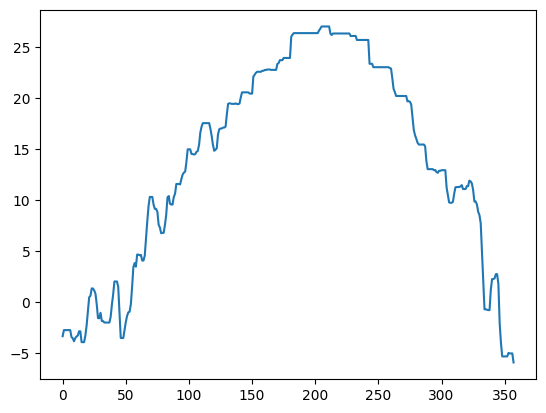

In [947]:
plt.plot(result)